In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydataset
import sys

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

# feature selection
from sklearn.feature_selection import RFE # Recursive Feature Elimination¶

# scaling
import sklearn.preprocessing as preprocess

import warnings
warnings.filterwarnings("ignore")


# set a default them for all my visuals
sns.set_theme(style="whitegrid")

sys.path.append("./util_")
# Personal libraries
import prepare_

**Get data**

In [2]:
# import tips data set
tips = pydataset.data("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
tips.isna().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [4]:
# Create a column named price_per_person. This should be the total bill divided by the party size.
tips["price_per_person"] = tips.total_bill / tips["size"]
tips.head(2)

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.495000
2,10.34,1.66,Male,No,Sun,Dinner,3,3.446667


**Split data**

In [5]:
train, validate, test = prepare_.split_data_(tips, random_state=59)
train.shape, validate.shape, test.shape

((146, 8), (49, 8), (49, 8))

**Set baseline**

In [6]:
# add a baseline columns
train["baseline"] = train.tip.mean()
train.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person,baseline
198,43.11,5.0,Female,Yes,Thur,Lunch,4,10.777500,3.108014
178,14.48,2.0,Male,Yes,Sun,Dinner,2,7.240000,3.108014
146,8.35,1.5,Female,No,Thur,Lunch,2,4.175000,3.108014
183,45.35,3.5,Male,Yes,Sun,Dinner,3,15.116667,3.108014
215,28.17,6.5,Female,Yes,Sat,Dinner,3,9.390000,3.108014


**Separate Feature and target**

In [7]:
# separate features from target
xtrain = train.select_dtypes("number").drop(columns=["tip", "baseline"])
ytrain = train.tip

# validation set
xval = validate.select_dtypes("number").drop(columns=["tip"])
yval = validate.tip

# testing set
xtest = test.select_dtypes("number").drop(columns=["tip"])
ytest = test.tip

**Feature Selection**

In [8]:

# make a model object to use in RFE process.
# The model is here to give us metrics on feature importance and model score
# allowing us to recursively reduce the number of features to reach our desired space
linear_model = LinearRegression()

# make a RFE object and fit
rfe = RFE(linear_model, n_features_to_select=2)
rfe.fit(xtrain,ytrain)

# get my top two features
xtrain.columns[rfe.support_]

Index(['size', 'price_per_person'], dtype='object')

In [9]:
# transform out selected features into a dataframe
x_train = pd.DataFrame(
    rfe.transform(xtrain),
    index=xtrain.index,
    columns = xtrain.columns[rfe.support_]
)
x_train.head()

,size,price_per_person
198,4.0,10.777500
178,2.0,7.240000
146,2.0,4.175000
183,3.0,15.116667
215,3.0,9.390000


**Scale features**

In [10]:
# build the scaler object
scaler = preprocess.StandardScaler()

# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
# y Target values: this is not being changed in any way(no predictions are being made)
x_train_scaled = scaler.fit_transform(X=x_train, y=ytrain)

# scale the validation and testing data
x_val_scaled = scaler.fit_transform(X=xval, y=yval)
x_test_scaled = scaler.fit_transform(X=xtest, y=ytest)

x_train_scaled[:3]

array([[ 1.52349271,  1.0060229 ],
       [-0.61525667, -0.22934947],
       [-0.61525667, -1.2997145 ]])

In [11]:
# convert to dataframe
x_train_scaled = pd.DataFrame(x_train_scaled)
x_train_scaled[x_train.columns] = x_train_scaled
x_train_scaled = x_train_scaled.drop(columns=[0,1])
x_train_scaled.head()

,size,price_per_person
0,1.523493,1.006023
1,-0.615257,-0.229349
2,-0.615257,-1.299715
3,0.454118,2.521355
4,0.454118,0.521478


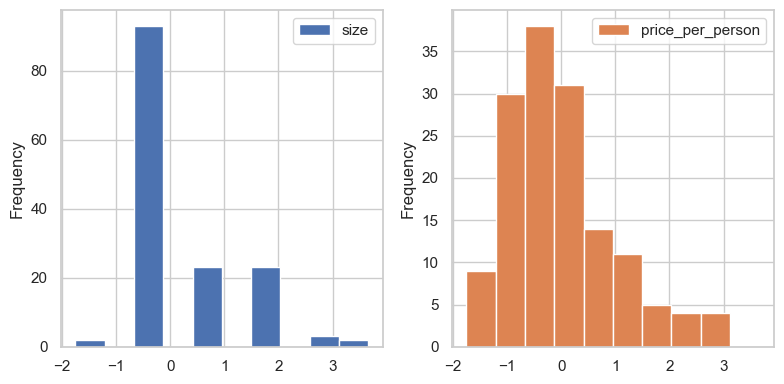

In [12]:
# create subpots of distribution of the features
x_train_scaled.plot.hist(subplots=True, layout=(1, 2), figsize=(8, 4),
              sharex=False, sharey=False, legend=True)
plt.tight_layout()

### Modeling

**Linear Regression (OLS): Training**

In [13]:
# MAKE THE THING: create the model object
linear_model = LinearRegression()

#1. FIT THE THING: fit the model to training data
OLSmodel = linear_model.fit(x_train_scaled, ytrain)

#2. USE THE THING: make a prediction
ytrain_pred = linear_model.predict(x_train_scaled)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(ytrain, ytrain_pred) ** (.5) # 0.5 to get the root

# root mean squeared error
print("RMSE for OLS:",rmse_train)

RMSE for OLS: 0.9685606105067803


In [14]:
# convert results into dataframe
result = pd.DataFrame({
    "target": ytrain,
    "OLS_prediction": ytrain_pred,
    "baseline_pred": train.baseline
})

result.head()

,target,OLS_prediction,baseline_pred
198,5.0,4.823735,3.108014
178,2.0,2.510351,3.108014
146,1.5,1.934272,3.108014
183,3.5,4.815049,3.108014
215,6.5,3.738700,3.108014


**Validate**

In [15]:
# convert to dataframe
x_val_scaled = pd.DataFrame(x_val_scaled)
x_val_scaled[xval.columns] = x_val_scaled
x_val_scaled = x_val_scaled[x_train.columns]

In [16]:
#2. USE THE THING: make a prediction
yval_pred = linear_model.predict(x_val_scaled)

#3. Evaluate: RMSE
rmse_val = mean_squared_error(yval, yval_pred) ** (.5) # 0.5 to get the root

# root mean squeared error
print("RMSE for OLS:",rmse_val)

RMSE for OLS: 1.1240590684628513


In [17]:
# convert results into dataframe
result = pd.DataFrame({
    "target": yval,
    "OLS_val_predi":yval_pred
})

result.head()

,target,OLS_val_predi
42,2.54,2.884244
160,2.00,3.650837
191,1.50,2.733083
22,2.75,3.125931
14,3.00,3.733676


In [23]:
# how important is each feature to the target
OLSmodel.coef_

array([0.77077615, 0.53820761])

In [22]:
print(f"OLS Regressor \nRMSE_train {rmse_train} \
\nRMSE_validate {rmse_val} \nR2_validate {explained_variance_score(yval, yval_pred)}")


OLS Regressor 
RMSE_train 0.9685606105067803 
RMSE_validate 1.1240590684628513 
R2_validate 0.27833891749564343
